In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import kneighbors_graph

import umap

import shutil
import os
from pathlib import Path

# ------------------------
# Load data
# ------------------------
df = pd.read_csv(r"../data/features.csv")

# Separate metadata and features
file_names = df["file_name"]
X = df.drop(columns=["file_name"])

# ------------------------
# Scale features
# ------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

C:\Users\ellio\AppData\Local\Temp\ipykernel_24684\134666520.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
c:\Users\ellio\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


c:\Users\ellio\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


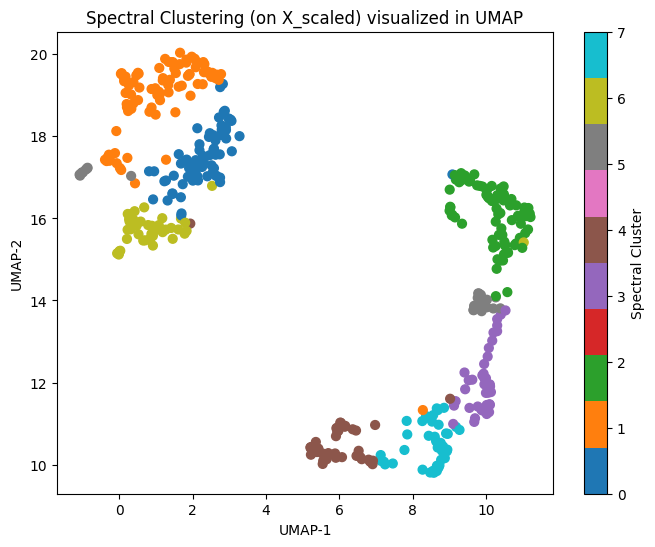

In [2]:
# ============================================================
# OPTION A (Recommended): Spectral clustering on kNN graph of ORIGINAL space
#   - This is the "proper" spectral clustering pipeline.
#   - Avoids UMAP distortion for the clustering step.
# ============================================================

# --- choose k for the kNN graph (often similar-ish to UMAP n_neighbors) ---
k = 15

# Build sparse kNN connectivity graph (order-invariant except for exact distance ties)
connectivity = kneighbors_graph(
    X_scaled,
    n_neighbors=k,
    mode="connectivity",     # unweighted adjacency; try "distance" if you want weights
    include_self=False,
    metric="minkowski",      # Euclidean
    p=2,
    n_jobs=-1
)

spectral = SpectralClustering(
    n_clusters=8,            # <-- SET THIS (see note below)
    affinity="nearest_neighbors",
    n_neighbors=k,
    assign_labels="kmeans",  # "kmeans" is common; "discretize" can be more deterministic/stable
    random_state=42
)

labels_spec = spectral.fit_predict(X_scaled)

df["cluster_spectral"] = labels_spec

# --- Visualization (use UMAP only for plotting, not for clustering) ---
umap_vis = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric="euclidean",
    random_state=42
)
X_umap_vis = umap_vis.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(
    X_umap_vis[:, 0],
    X_umap_vis[:, 1],
    c=labels_spec,
    cmap="tab10",
    s=40
)
plt.colorbar(label="Spectral Cluster")
plt.title("Spectral Clustering (on X_scaled) visualized in UMAP")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

In [ ]:
# Load features once (outside loop)
features_csv = Path("../data/features.csv")  # relative to notebook location
features_df = pd.read_csv(features_csv)

# Get unique clusters and get 5 representative samples from each cluster
representative_samples = []
for cluster in np.unique(labels_spec):
    cluster_samples = df[df["cluster_spectral"] == cluster]
    representative_samples.append(cluster_samples.sample(n=5, random_state=42))
    print(f"Cluster {cluster}:")
    print(cluster_samples["file_name"].values[:5])
    
    # Merge cluster samples with features_df to get all feature values
    merged_cluster_samples = pd.merge(cluster_samples, features_df, on="file_name", how="left")
    
    # Save merged data to CSV
    output_folder = Path(f"../visuals/rep_samples/Spectral_Cluster/{cluster}")
    if output_folder.exists():
        shutil.rmtree(output_folder)
    output_folder.mkdir(parents=True, exist_ok=True)
    output_file = output_folder / f"cluster_{cluster}.csv"
    merged_cluster_samples.to_csv(output_file, index=False)
    
    # Copy representative sample plots
    for file in cluster_samples["file_name"].values[:5]:
        png_file = file.replace(".csv", ".png")
        src = Path(f"../visuals/boiling_plots/{png_file}")
        dst = output_folder / png_file
        
        # Only copy if source exists
        if src.exists():
            shutil.copy(src, dst)
        else:
            print(f"Warning: {src} not found, skipping")

Cluster 0:
['MATLAB 1-00 PM Fri, Jun 28, 2024 Run8 .csv'
 'MATLAB 1-07 PM Fri, May 31, 2024 Run3 .csv'
 'MATLAB 1-17 PM Tue, Sep 10, 2024 Run11 .csv'
 'MATLAB 1-19 PM Tue, Sep 10, 2024 Run12 .csv'
 'MATLAB 1-30 PM Tue, Sep 10, 2024 Run16 .csv']
Cluster 1:
['Calm_to_Boiling_50V_on_StartT65.csv'
 'MATLAB 1-14 PM Tue, Sep 10, 2024 Run10 .csv'
 'MATLAB 1-21 PM Thu, Nov 7, 2024 Run10 .csv'
 'MATLAB 1-25 PM Thu, Nov 7, 2024 Run11 .csv'
 'MATLAB 1-29 PM Thu, Nov 7, 2024 Run12 .csv']
Cluster 2:
['MATLAB 1-00 PM Thu, Aug 22, 2024 Run1.csv'
 'MATLAB 1-04 PM Thu, Aug 22, 2024 Run2.csv'
 'MATLAB 1-04 PM Tue, Sep 10, 2024 Run9 .csv'
 'MATLAB 1-05 PM Thu, Aug 22, 2024 Run3 .csv'
 'MATLAB 1-10 PM Thu, Aug 22, 2024 Run4 .csv']
Cluster 3:
['MATLAB 1-18 PM Fri, May 31, 2024 Run4 .csv'
 'MATLAB 1-27 PM Fri, Sep 13, 2024 Run0 .csv'
 'MATLAB 1-32 PM Tue, Jun 4, 2024 Run1.csv'
 'MATLAB 1-34 PM Tue, Jun 11, 2024 Run0 .csv'
 'MATLAB 1-52 PM Fri, Jun 14, 2024 Run4 .csv']
Cluster 4:
['MATLAB 1-07 PM Fri, Jun 14